<font color="red"><h1>OpenSees Examples Manual using OpenSeesPy!</h1></font> 

You can find the original OpenSees examples manual using Tcl [here](https://opensees.berkeley.edu/wiki/index.php/Examples_Manual). (Original Examples in Tcl by Silvia Mazzoni & Frank McKenna, 2006.)

<h2><u>Simulation Process</u></h2>

In each of the following examples, an input file (python script) is created to conduct a simulation in OpenSees. The process of creating the input file is broken-down into three main parts: 
### 1. Model definition (General)
### 2. Output specification
### 3. Loads and Analysis
- Model definition (Gravity loads)
- Analysis generation (Gravity loads)
- Model definition (Lateral loads)
- Analysis generation (Lateral loads)




<h2><u>OpenSees Example 1a</u></h2>

### 2D Elastic Cantilever Column -- Static Pushover

This example has previously been converted to OpenSeesPy by SilviaMazzoni, 2020. The script can be found on her github page [here](https://github.com/silviamazzoni/OpenSeesPy_ExamplesManual/blob/main/BraineryBytes_OpenSees_Examples_Manual_Example_1a_Elastic_Cantilever_Column_Pushover.ipynb).

Introductory example 1a is a simple model of an elastic cantilever column. 

<img src="https://opensees.berkeley.edu/wiki/images/e/ec/Example1a_Push.GIF">


In [179]:
# Import required modules
import openseespy.opensees as ops
import opsvis as opsv
import os
import numpy as np
import matplotlib.pyplot as plt

import ipywidgets as widgets
from IPython.display import display

In [180]:
# --------------------------------------------------------------------------------------------------
# Example 1a. cantilever 2D
# static pushover analysis with gravity.
# elasticBeamColumn ELEMENT
# Silvia Mazzoni and Frank McKenna, 2006

# SET UP ----------------------------------------------------------------------------
if not os.path.exists('Data'): # Create Data directory
    os.mkdir('Data')

## Units

In [181]:
m = 1.0
s = 1.0
kg = 1.0

N = kg * m / s ** 2
Pa = N / m ** 2

# Conversions
inches = 0.0254 * m
ft = 12 * inches
kip = 4448.2216152548 * N
ksi = 6.895 * 10 ** 6 * Pa

## Input Variables

In [182]:
# Initialize the variable
colL = 36

# Create an IntSlider widget
slider = widgets.IntSlider(value=0, min=0, max=100, step=1, description='Column Length:')

# Function to update the variable based on slider value
def update_variable(change):
    global colL
    colL = change['new']
    # print(f'Updated colL: {colL}')

# Observe changes in the slider's value
slider.observe(update_variable, names='value')

# Display the slider
display(slider)

IntSlider(value=0, description='Column Length:')

In [183]:
print(colL)

colL = colL * ft # Column length

# Nodal coordinates
n1 = (0.0, 0.0) # Use floating point values
n2 = (0.0, colL)

# Cross-sectional dimensions
b = 5 * ft # Breadth
d = 5 * ft # Depth
A = b * d # Area

# Elastic Modulus
E = 4227 * ksi

# Moment of Inertia
Iz = (b * d ** 3) / 12

# Loads/Actions
Py = -2000.0 * kip # Gravity load

36


We will perform a displacement-controlled static analysis, so any non-zero value for the lateral load can be used. The specific value of the lateral load will not affect the results.

In [184]:
Px = 1 # Lateral load

g = 9.81 # Gravitational acceleration (N / kg)

# Nodal mass
mass_x = abs(Py) / g # kg
print(f'The nodal mass value corresponding to the horizontal DOF is {mass_x:.0f} kg') # 
massValues = [mass_x, 1 * 10 ** -9, 0.0] # ndf nodal mass values corresponding to each DOF


The nodal mass value corresponding to the horizontal DOF is 906875 kg


## Model definition (General)

Wipe command:  [OpenSeesPy](https://openseespydoc.readthedocs.io/en/latest/src/wipe.html), [OpenSees Tcl](https://opensees.berkeley.edu/wiki/index.php?title=Wipe_Command)

In [185]:
# wipe()

ops.wipe()  # Clear opensees model

Model command:  [OpenSeesPy](https://openseespydoc.readthedocs.io/en/latest/src/model.html), [OpenSees Tcl](https://opensees.berkeley.edu/wiki/index.php?title=Model_command)

In [186]:
# model('basic', '-ndm', ndm, '-ndf', ndf=ndm*(ndm+1)/2)

ops.model('basic', '-ndm', 2, '-ndf', 3)    # 2 dimensions, 3 dof per node

Node command:  [OpenSeesPy](https://openseespydoc.readthedocs.io/en/latest/src/node.html), [OpenSees Tcl](https://opensees.berkeley.edu/wiki/index.php?title=Node_command)

In [187]:
# # define GEOMETRY -------------------------------------------------------------
# # nodal coordinates:
# ops.node(1, *n1)  # node , X Y
# ops.node(2, *n2)

# Create nodes
nodes = (n1, n2)
for num, node in enumerate(nodes, start = 1): # https://docs.python.org/3/library/functions.html#enumerate
    ops.node(num, *node)

In [188]:
# Set boundary conditions
# Single point constraints -- Boundary Conditions
ops.fix(1,1,1,1)     #  node DX DY RZ

Text(0.5, 1.0, 'plot_model after defining nodes')

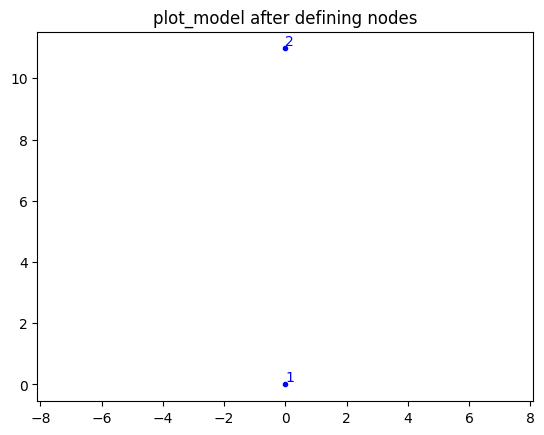

In [189]:
opsv.plot_model()
plt.title('plot_model after defining nodes')

In [190]:
# Define ELEMENTS -------------------------------------------------------------
# define geometric transformation: performs a linear geometric transformation of beam stiffness
# and resisting force from the local-coordinate system to the global-coordinate system
# geomTransf('Linear', transfTag, '-jntOffset', *dI, *dJ)
ops.geomTransf('Linear', 1)     #  associate a tag to transformation

In [191]:
# # Define Materials
# ops.uniaxialMaterial("Elastic", 1, E)

In [192]:
# connectivity: (make A very large, 10e6 times its actual value)
# element elasticBeamColumn eleTag iNode jNode A E Iz transfTag
ops.element('elasticBeamColumn', 1, 1, 2, A * 10 ** 6, E, Iz, 1)     # element elasticBeamColumn 1 1 2 3600000000 4227 1080000 1;

Text(0.5, 1.0, 'plot_model after defining elements')

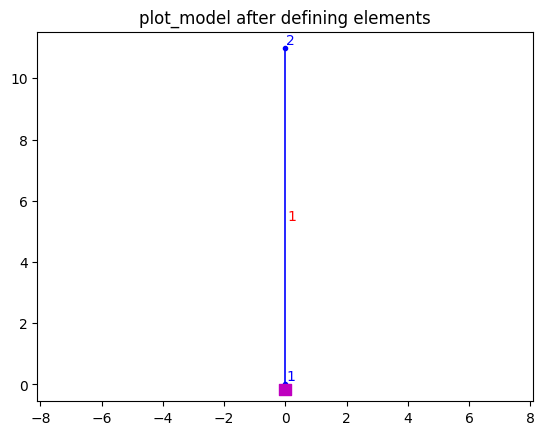

In [193]:
opsv.plot_model()
plt.title('plot_model after defining elements')

In [194]:
# nodal masses: Time - 23:30, 32:20
ops.mass(2, *massValues)     #  node ,  Mass=Weight/g.

## Output specification

In [195]:
# Define RECORDERS -------------------------------------------------------------

# https://openseespydoc.readthedocs.io/en/latest/src/nodeRecorder.html#node-recorder-command
# recorder('Node', '-file', filename, '-time', '-node', *nodeTags=[], '-dof', *dofs=[], respType)
dofs = [1, 2, 3]
ops.recorder('Node', '-file', 'Data/DispFreeEx1aPush.out', '-time', '-node', 2, '-dof', *dofs, 'disp')     #  displacements of free node
ops.recorder('Node', '-file', 'Data/DispBaseEx1aPush.out', '-time', '-node', 1, '-dof', *dofs, 'disp')     #  displacements of support node
ops.recorder('Node', '-file', 'Data/ReacBaseEx1aPush.out', '-time', '-node', 1, '-dof', *dofs, 'reaction')     #  support reaction

# https://openseespydoc.readthedocs.io/en/latest/src/elementRecorder.html#element-recorder-command
# recorder('Element', '-file', filename, '-time', '-ele', *eleTags=[], '-eleRange', startEle, endEle, '-region', regionTag, *args)
ops.recorder('Element', '-file', 'Data/FColEx1aPush.out', '-time', '-ele', 1, 'globalForce')     #  element forces -- column
ops.recorder('Element', '-file', 'Data/DColEx1aPush.out', '-time', '-ele', 1, 'deformation')     #  element deformations -- column

34

## Loads and Analysis

### Model definition (Gravity Loads)

In [196]:
# Define GRAVITY Loads-------------------------------------------------------------
ops.timeSeries('Linear', 1)  # timeSeries Linear 1;

# Define Load Pattern
ops.pattern('Plain', 1, 1)
ops.load(2, 0.0, Py, 0.0)   #  node , FX FY MZ -- superstructure-weight

### Analysis generation (Gravity loads)

In [197]:
ops.wipeAnalysis()     # adding this to clear Analysis module 
ops.system('BandGeneral')     #  how to store and solve the system of equations in the analysis
ops.numberer('Plain')     #  renumber dofs to minimize band-width (optimization), if you want to
ops.constraints('Plain')     #  how it handles boundary conditions
ops.integrator('LoadControl',0.1)     #  determine the next time step for an analysis,   apply gravity in 10 steps
ops.algorithm('Newton')     #  use Newtons solution algorithm: updates tangent stiffness at every iteration
ops.analysis('Static')     #  define type of analysis static or transient

ops.test('NormDispIncr',1.0e-8,6)     #  determine if convergence has been achieved at the end of an iteration step
ops.analyze(10)     #  perform gravity analysis
ops.loadConst('-time',0.0)     #  hold gravity constant and restart time

100


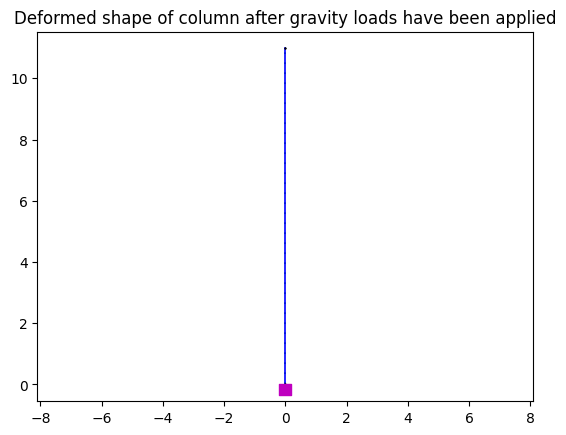

In [198]:
sfac = opsv.plot_defo(sfac = 100)
plt.title('Deformed shape of column after gravity loads have been applied')
print(sfac)

### Model definition (Lateral loads)

In [199]:
# define LATERAL load -------------------------------------------------------------
# Lateral load pattern
ops.timeSeries('Linear', 2)     # timeSeries Linear 2;
# define Load Pattern
ops.pattern('Plain', 2, 2) # 
ops.load(2, Px, 0.0, 0.0)    #  node , FX FY MZ -- REPRESENTATIVE lateral load at top node

### Analysis generation (Lateral loads)

In [200]:
# pushover: diplacement controlled static analysis
# Note we do not wipe the analysis

disp = 100 * inches
print(f'Horizontal displacement at top of column is set to be: {disp} metres')
steps = 1000 # Must be an integer
incr = disp / steps
ops.integrator('DisplacementControl', 2, 1, incr)     #  switch to displacement control, for node 2, dof 1, 0.1 increment
ops.analyze(steps)

Horizontal displacement at top of column is set to be: 2.54 metres


0

In [201]:
print('Done!')

Done!


## Output

Text(0.5, 1.0, 'Deformed shape of column (Scale factor: 1)')

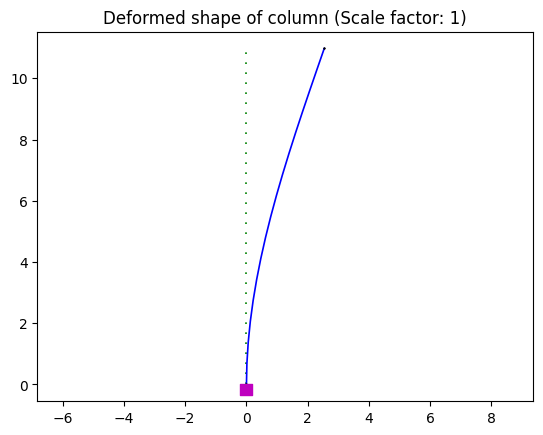

In [202]:
sfac = opsv.plot_defo(sfac = 1)
plt.title(f'Deformed shape of column (Scale factor: {sfac})')

Display the applied loads.

<Axes: >

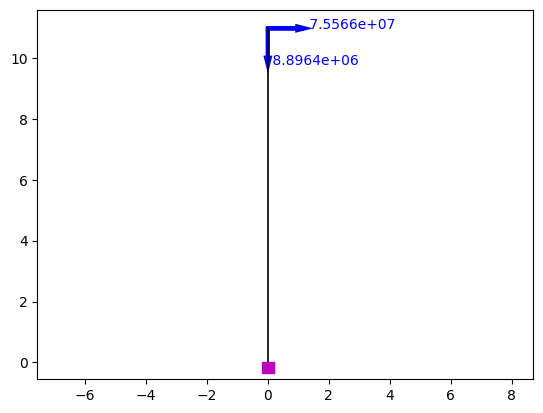

In [203]:
opsv.plot_loads_2d(nep=17, sfac=False, fig_wi_he=False, fig_lbrt=False, 
                   fmt_model_loads={'color': 'black', 'linestyle': 'solid', 'linewidth': 1.2, 'marker': '', 'markersize': 1}, 
                   node_supports=True, truss_node_offset=0, ax=False)

The lateral load shown above is the load required to produce the specified horizontal displacement assuming the column remains elastic. We can check/compare this value with that given by the theoretical formula for maximum displacement of a cantilever beam with a point load at its free end.

In [204]:
# Check the applid horizontal load produces the expected displacement (Include picture of theoretical formula)
expected_disp = (7.5566 * 10 ** 7 * colL ** 3) / (3 * E * Iz)
print(f'Maximum displacement: {expected_disp:.3f} m')

Maximum displacement: 2.540 m


As expected, this agrees with the displacement we specified for the displacement controlled analysis.

In [205]:
ops.printModel()

Current Domain Information
	Current Time: 7.55662e+07
	Committed Time: 7.55662e+07
NODE DATA: NumNodes: 2

numComponents: 2

 Node: 1
	Coordinates  : 0 0 
	Disps: 0 0 0 
	 unbalanced Load: 0 0 0 
	 reaction: -7.55662e+07 8.89644e+06 8.29173e+08 
	ID : -1 -1 -1 


 Node: 2
	Coordinates  : 0 10.9728 
	Disps: 2.54 -1.44211e-09 -0.347222 
	 unbalanced Load: 7.55662e+07 -8.89644e+06 0 
	 reaction: -2.98023e-08 0 -1.19209e-07 
	Mass : 
906875 0 0 
0 1e-09 0 
0 0 0 

	 Rayleigh Factor: alphaM: 0
	 Rayleigh Forces: 0 0 0 
	ID : 0 1 2 

ELEMENT DATA: NumEle: 1

numComponents: 1

ElasticBeam2d: 1
	Connected Nodes: 1 2 
	CoordTransf: 1
	mass density:  0, cMass: 0
	release code:  0
	End 1 Forces (P V M): 8.89644e+06 7.55662e+07 8.29173e+08
	End 2 Forces (P V M): -8.89644e+06 -7.55662e+07 -1.19209e-07

SP_Constraints: numConstraints: 3

numComponents: 3
SP_Constraint: 0	 Node: 1 DOF: 1 ref value: 0 current value: 0 initial value: 0
SP_Constraint: 1	 Node: 1 DOF: 2 ref value: 0 current value: 0 init

End of Run


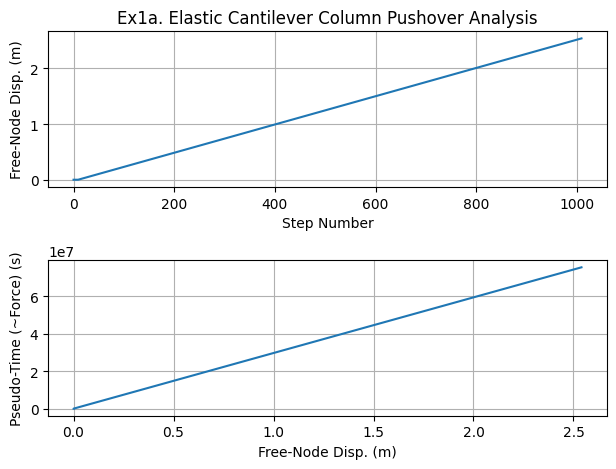

In [206]:
# Load the data
fname3 = 'Data/DispFreeEx1aPush.out'
dataDFree = np.loadtxt(fname3)

# Create a figure and axes instances
fig, axes = plt.subplots(2, 1)

# Plot on the first axis
axes[0].set_title('Ex1a. Elastic Cantilever Column Pushover Analysis')
axes[0].grid(True)
axes[0].plot(dataDFree[:, 1])
axes[0].set_xlabel('Step Number')
axes[0].set_ylabel('Free-Node Disp. (m)')

# Plot on the second axis
axes[1].grid(True)
axes[1].plot(dataDFree[:, 1], dataDFree[:, 0])
axes[1].set_xlabel('Free-Node Disp. (m)')
axes[1].set_ylabel('Pseudo-Time (~Force) (s)')

# Display the plot
plt.tight_layout()  # Adjust layout to prevent overlap

# End of script
print('End of Run')